In [121]:
!pip install -r requirements.txt

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
# sklearn - preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# sklearn - metrics
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader ,SVD ,accuracy 
from surprise.model_selection import cross_validate, train_test_split

import mlflow


# Data Preprocessing

In [ ]:
import utils

# Load the dataset
df = utils.load_data('data/amazon_fine_food_reviews.csv')

# Clean the data by removing NaN values
df = utils.clean_data(df)

# Remove specific columns from the DataFrame
columns_to_remove = ['ProfileName','Id','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary','Text'] 
df = utils.remove_columns(df, columns_to_remove)

# Remove duplicate rows
df_no_duplicates = utils.remove_duplicates(df)
print(df.shape)
print(df_no_duplicates.shape)
df = df_no_duplicates.copy()

In [2]:
df.head()

,ProductId,UserId,Score
0,B001E4KFG0,A3SGXH7AUHU8GW,5
1,B00813GRG4,A1D87F6ZCVE5NK,1
2,B000LQOCH0,ABXLMWJIXXAIN,4
3,B000UA0QIQ,A395BORC6FGVXV,2
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5


In [3]:
df.isna().sum()

ProductId    0
UserId       0
Score        0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

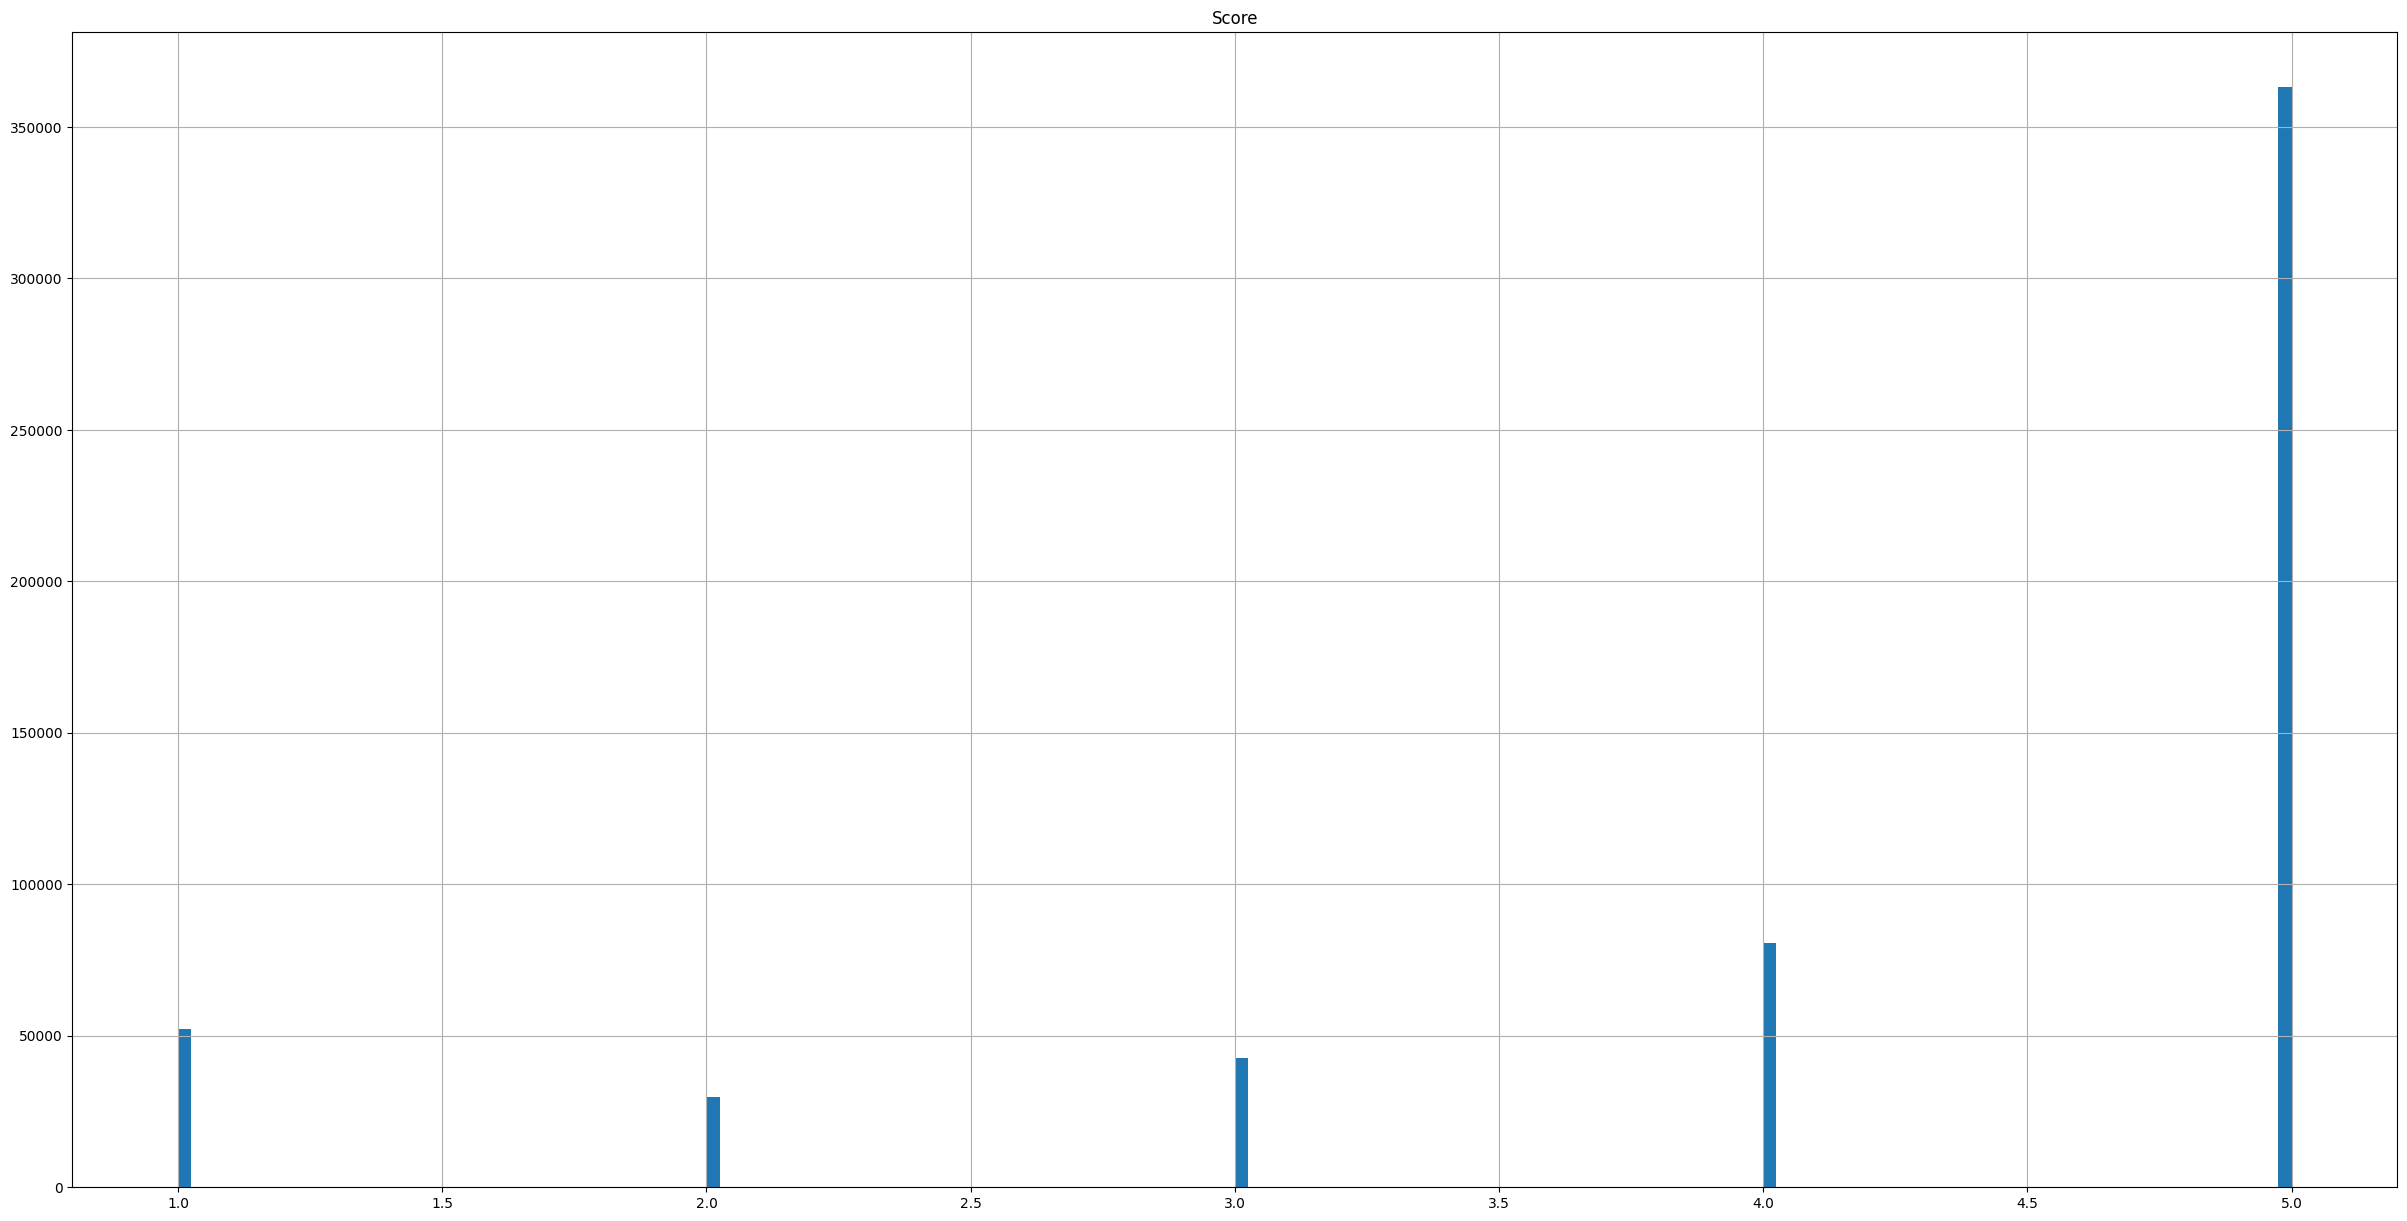

In [4]:
df.hist(bins=160, figsize=(30, 15))
plt.show

In [8]:
# Count the number of reviews for each user
review_counts = df['UserId'].value_counts().reset_index()

review_counts.head(20)

,UserId,count
0,A3OXHLG6DIBRW8,422
1,AY12DBB0U420B,389
2,A1YUL9PCJR3JTY,350
3,A281NPSIMI1C2R,322
4,A1Z54EM24Y40LL,251
5,A2MUGFV2TDQ47K,201
6,AQQLWCMRNDFGI,167
7,AZV26LP92E6WU,167
8,AY1EF0GOH80EK,157
9,A1UQBFCERIP7VJ,157


In [9]:
''''
We will use the users with a minimum number of reviews = 10 and ignore the rest.
Make a mapping to keep the relation between the userid column and other columns unchanged.
Use the users with min_reviews number or more and make the other with id NaN.
Drop the rows which have NaN values in userid column.
'''
min_reviews= 10

mapping = review_counts[review_counts['count'] >= min_reviews].set_index('UserId')['count'].to_dict()
df_new = df.copy()
#create a set of UserIds with counts >= min_reviews
valid_user_ids = set(review_counts[review_counts['count'] >= min_reviews]['UserId'])

#update UserId in the new df
df_new['UserId'] = df_new['UserId'].where(df_new['UserId'].isin(valid_user_ids), np.nan)

df_new.head(20)

,ProductId,UserId,Score
0,B001E4KFG0,NaN,5
1,B00813GRG4,NaN,1
2,B000LQOCH0,NaN,4
3,B000UA0QIQ,NaN,2
4,B006K2ZZ7K,NaN,5
5,B006K2ZZ7K,NaN,4
6,B006K2ZZ7K,NaN,5
7,B006K2ZZ7K,NaN,5
8,B000E7L2R4,NaN,5
9,B00171APVA,NaN,5


In [10]:
#now the new df have the user id with the highest number of reviews
#The rest ids become with value NaN, we will drop then
df_new['UserId'].isna().sum()

427722

In [11]:
df_new =df_new.dropna(subset=['UserId'])
df_new.isna().sum()

ProductId    0
UserId       0
Score        0
dtype: int64

In [12]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134908 entries, 11 to 568447
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  134908 non-null  object
 1   UserId     134908 non-null  object
 2   Score      134908 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.1+ MB


In [13]:
unique_values = df_new['ProductId'].unique()
print(f"Number of unique values in 'ProductId': {len(unique_values)}")

Number of unique values in 'ProductId': 27282


In [14]:
num_cols = ['Score']
categ_cols = []
ready_cols = list(set(df_new.columns.tolist()) - set(num_cols) - set(categ_cols))

print('Numerical Cols \t', num_cols)
print()
print('Categorical Cols \t', categ_cols)
print()
print('Ready Cols \t', ready_cols)

Numerical Cols 	 ['Score']

Categorical Cols 	 []

Ready Cols 	 ['ProductId', 'UserId']


# **We will try three approaches:**

>**1- User-user collaborative based filtering**

>**2- Item-item collaborative based filtering**

>**3- Singular value decomposition (SVD)**

**User-user collaborative based filtering**
This method captures the underlying pattern of interests of like-minded users and uses the choices and preferences of similar users to suggest new items.

In order to make a new recommendation to a user, the user-user method roughly tries to identify users with the most similar “interactions profile” (nearest neighbours) in order to suggest movies that are the most popular among these neighbours (and that are “new” to our user). This method is said to be “user-centred” as it represents users based on their interactions with items and evaluates distances between users.

In [15]:
# Define a Reader object to specify the rating scale
reader = Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1, 5))

# Load the data into a Surprise dataset
##notice that we use new df which have number of ratings more than min_reviews for each user
data = Dataset.load_from_df(df_new[['UserId', 'ProductId', 'Score']], reader)

# Compute similarities between users using cosine distance
sim_options = {"name": "cosine",
               "user_based": True}  

# Evaluate the model 
k = 30  #desired number of neighbors
user = KNNWithMeans(k=k, sim_options=sim_options)
cv = cross_validate(user, data, cv=5, measures=['RMSE', 'MAE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9257  0.9328  0.9376  0.9407  0.9325  0.9339  0.0051  
MAE (testset)     0.6079  0.6113  0.6172  0.6152  0.6156  0.6134  0.0034  
Fit time          4.02    3.88    3.79    3.84    3.83    3.87    0.08    
Test time         3.15    3.16    3.32    3.29    3.27    3.24    0.07    


**Item-item collaborative based filtering**
To tackle the issues with user-based collaborative based techniques, item-based collaborative techniques analyze the user-item matrix and identify relationships between different items (Sarwar et al.,2001). The item-based recommendation system then makes recommendations based on the discovered linear relationships (similarities) amongst the items. This method is more stable compared to user based collaborative filtering because the average item has a lot more ratings than the average user. So an individual rating doesn’t impact as much.

The idea of item-item method is to find movies similar to the ones the user already “positively” interacted with. Two items are considered to be similar if most of the users that have interacted with both of them did it in a similar way. This method is said to be “item-centred” as it represents items based on interactions users had with them and evaluates distances between those items.

In [16]:
# Compute similarities between items using cosine distance
sim_options = {"name": "pearson",
               "user_based": False}  

# Fit the KNNwithmeans algorithm to the training set
k= 10
item_based = KNNWithMeans(k=k, sim_options=sim_options)

# Evaluate the model 
cv = cross_validate(item_based, data, cv=5, measures=['RMSE','MAE'], verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8927  0.9059  0.8932  0.9064  0.9018  0.9000  0.0060  
MAE (testset)     0.5034  0.5098  0.5038  0.5123  0.5069  0.5072  0.0034  
Fit time          33.73   32.25   31.86   31.56   31.79   32.24   0.78    
Test time         1.52    1.35    1.35    1.39    1.52    1.42    0.08    


**Singular value decomposition (SVD)**

Unlike Memory-Based Approaches, Model-Based procedures facilitate machine learning techniques such as Singular Value Decomposition (SVD) and Matrix Factorization models to predict the end user's rating on unrated items.

We will be using SVD to build our recommender engine. We utilize the results of singular value decomposition (SVD) to fill the vacant ratings and then use the item based method to produce the prediction of unrated items.

Formally, SVD is decomposition of a matrix R which is the utility matrix with m equal to the number of users and m number exposed items (movies) into the product of three matrices:

U is a left singular orthogonal matrix, representing the relationship between users and latent factors (Hopcroft & Kannan, 2012)

Σ is a diagonal matrix (with positive real values) describing the strength of each latent factor

V(transpose) is a right singular orthogonal matrix, indicating the similarity between items and latent factors.

In [17]:
svd = SVD(random_state=0, lr_all= 0.1)
cv = cross_validate(svd, data, cv=5, measures=['RMSE','MAE'], verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8025  0.7922  0.7886  0.8079  0.7978  0.7978  0.0069  
MAE (testset)     0.4837  0.4744  0.4701  0.4826  0.4754  0.4772  0.0052  
Fit time          2.27    2.28    2.29    2.34    2.31    2.30    0.03    
Test time         0.47    0.28    0.27    0.27    0.47    0.35    0.10    


**Using SVD gives us a RMSE score of 0.798   which is promising and the best of the 3 we've tested. We will go ahead and train this model using the entire dataset.**

# **Submission using SVD**

In [168]:
# Define a Reader object to specify the rating scale
reader = Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1, 5))

# Load the data into a Surprise dataset
##notice that we use new df which have number of ratings more than min_reviews for each user
data = Dataset.load_from_df(df_new[['UserId', 'ProductId', 'Score']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

In [169]:
# Instantiate the SVD model
svd = SVD(random_state=0, lr_all= 0.1)

svd.fit(trainset)

In [170]:
# Predict ratings for the test set
predictions = svd.test(testset)

# Compute and print RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 0.7955
MAE:  0.4748


In [20]:
testset

[('ARWRBORADGA3G', 'B005K4Q1VI', 5.0),
 ('A35LT14WG5BX0T', 'B004OVATO8', 4.0),
 ('A318D41ZQ9OPNA', 'B001E18K8S', 3.0),
 ('AX1Z5RQ1LWMM2', 'B000OIT8T2', 5.0),
 ('A26NFIQ7KWI8Y7', 'B007OXJLM4', 4.0),
 ('A3F2VVIQIY6U64', 'B005BPVB84', 4.0),
 ('A9GQR7CMQERSS', 'B00141SO7A', 1.0),
 ('A15JB2HEZ6RKGW', 'B006MONQMC', 5.0),
 ('A2WYP6MZRK4G4A', 'B0029NIFXK', 5.0),
 ('A19ZK2D5664XKL', 'B000EQYQBO', 5.0),
 ('AWLK6NSSV0YNA', 'B004728MI4', 5.0),
 ('AS0SPE5TEM74Z', 'B004JLGDJI', 5.0),
 ('AZA55FJD7CCZN', 'B005VOONKI', 4.0),
 ('A3ACCH1UM0OKVU', 'B000WVYB8Y', 5.0),
 ('ACFPHOYVB71V4', 'B000G6MBUA', 5.0),
 ('ASPZBFGF4AS8H', 'B000MIDRNW', 5.0),
 ('A3FG0FQHNV2UP2', 'B007RTR8UM', 2.0),
 ('AI8EMB0HUC6Z5', 'B004BKLHOS', 5.0),
 ('A1MLQY4WBCWD31', 'B001SIRU42', 3.0),
 ('ADS99W8WMEXZ2', 'B005VOOL00', 4.0),
 ('A20J0NBT6FWXXM', 'B0041CIR62', 5.0),
 ('A37AO20OXS51QA', 'B000T3KTJA', 2.0),
 ('AUOA7P6T8JXSE', 'B0012BUR8Q', 5.0),
 ('AO09RWV40IX78', 'B000AY9U20', 5.0),
 ('A39ZG9XWPS3JU7', 'B005HB4HHO', 5.0),
 ('A15LK8DSF

In [18]:
# Estimate ratings for all products for the specified user
user_id = 'A383XURHVF8ON6'  # Replace with the actual UserId
product_ids = df_new['ProductId'].unique()  # Get all ProductIds
predictions = []

for product_id in product_ids:
    predicted_rating = svd.predict(user_id, product_id).est
    predictions.append((product_id, predicted_rating))

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['ProductId', 'PredictedRating'])

# Get the top 10 products
top_10_products = predictions_df.sort_values(by='PredictedRating', ascending=False).head(20)

print(top_10_products)


        ProductId  PredictedRating
22694  B00488N8KY              5.0
2599   B001GVIUXQ              5.0
6213   B000EQYSLC              5.0
6214   B000SQMJE6              5.0
1344   B00434J154              5.0
13235  B000FD9314              5.0
11831  B0046GSTUM              5.0
23614  B001VPCDFS              5.0
6232   B0002CRZRW              5.0
9066   B000EA3M92              5.0
6239   B001ET5Y4I              5.0
6240   B000RJU8VU              5.0
1321   B000FKAYO2              5.0
25366  B004JM3LN8              5.0
6245   B001EO5ZCY              5.0
11816  B000F6SNQM              5.0
25379  B001OKGBAS              5.0
4183   B005DQCP9A              5.0
21304  B001EPQVUI              5.0
14396  B002ZBE67K              5.0


# **Using SVD & KNN_means in Ensamble Learning:**

In [172]:
# Instantiate the SVD model
svd_model = SVD(random_state=0, lr_all=0.1)

# Train the SVD model on the training set
svd_model.fit(trainset)

# Define and train KNNWithMeans model for user-based collaborative filtering
sim_options_user_knn = {
    'name': 'cosine',  # Use Pearson correlation for similarity
    'user_based': True  # This is user-user collaborative filtering
}

knn_user_model = KNNWithMeans(k=30, sim_options=sim_options_user_knn)
knn_user_model.fit(trainset)

# Define and train KNNWithMeans model for item-item collaborative filtering
sim_options_item_knn = {
    'name': 'pearson',  # Use Pearson correlation for similarity
    'user_based': False  # This is item-item collaborative filtering
}

knn_item_model = KNNWithMeans(k=10 ,sim_options=sim_options_item_knn)
knn_item_model.fit(trainset)

# Generate predictions
knn_user_predictions = knn_user_model.test(testset)
knn_item_predictions = knn_item_model.test(testset)
svd_predictions = svd_model.test(testset)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [23]:
# # Create a test set from the training data to check the overfitting
# trainset_test = []

# for uid in trainset.all_users():
#     # Get the list of (item_id, rating) pairs for the user
#     user_ratings = trainset.ur[uid]  # This is a list of (item_id, rating) tuples
#     for iid, rating in user_ratings:
#         trainset_test.append((uid, iid, rating))
        
# # Generate predictions for the training set
# knn_user_predictions = knn_user_model.test(trainset_test)
# knn_item_predictions = knn_item_model.test(trainset_test)
# svd_predictions = svd_model.test(trainset_test)

In [24]:
len(testset)
print(testset)

[('ARWRBORADGA3G', 'B005K4Q1VI', 5.0), ('A35LT14WG5BX0T', 'B004OVATO8', 4.0), ('A318D41ZQ9OPNA', 'B001E18K8S', 3.0), ('AX1Z5RQ1LWMM2', 'B000OIT8T2', 5.0), ('A26NFIQ7KWI8Y7', 'B007OXJLM4', 4.0), ('A3F2VVIQIY6U64', 'B005BPVB84', 4.0), ('A9GQR7CMQERSS', 'B00141SO7A', 1.0), ('A15JB2HEZ6RKGW', 'B006MONQMC', 5.0), ('A2WYP6MZRK4G4A', 'B0029NIFXK', 5.0), ('A19ZK2D5664XKL', 'B000EQYQBO', 5.0), ('AWLK6NSSV0YNA', 'B004728MI4', 5.0), ('AS0SPE5TEM74Z', 'B004JLGDJI', 5.0), ('AZA55FJD7CCZN', 'B005VOONKI', 4.0), ('A3ACCH1UM0OKVU', 'B000WVYB8Y', 5.0), ('ACFPHOYVB71V4', 'B000G6MBUA', 5.0), ('ASPZBFGF4AS8H', 'B000MIDRNW', 5.0), ('A3FG0FQHNV2UP2', 'B007RTR8UM', 2.0), ('AI8EMB0HUC6Z5', 'B004BKLHOS', 5.0), ('A1MLQY4WBCWD31', 'B001SIRU42', 3.0), ('ADS99W8WMEXZ2', 'B005VOOL00', 4.0), ('A20J0NBT6FWXXM', 'B0041CIR62', 5.0), ('A37AO20OXS51QA', 'B000T3KTJA', 2.0), ('AUOA7P6T8JXSE', 'B0012BUR8Q', 5.0), ('AO09RWV40IX78', 'B000AY9U20', 5.0), ('A39ZG9XWPS3JU7', 'B005HB4HHO', 5.0), ('A15LK8DSFQZZ52', 'B004YV80OE', 3.0

In [173]:
# Define weights for SVD and KNN
weight_svd = 0.7  # Weight for SVD predictions
weight_knn_user = 0.15  # Weight for user-based KNN predictions
weight_knn_item = 0.15  # Weight for item-based KNN predictions

# Combine predictions using weighted averaging
combined_predictions = []
for knn_user_pred, knn_item_pred, svd_pred in zip(knn_user_predictions, knn_item_predictions, svd_predictions):
    # Calculate the weighted average of the predicted ratings
    weighted_avg_rating = (weight_knn_user * knn_user_pred.est + 
                           weight_knn_item * knn_item_pred.est + 
                           weight_svd * svd_pred.est) / (weight_knn_user + weight_knn_item + weight_svd)
    
    # Create a new Prediction object with the weighted average rating
    combined_pred = knn_user_pred.__class__(uid=knn_user_pred.uid, 
                                             iid=knn_user_pred.iid, 
                                             est=weighted_avg_rating, 
                                             r_ui=knn_user_pred.r_ui,  # Actual rating
                                             details=knn_user_pred.details)  # Include details

    combined_predictions.append(combined_pred)


In [174]:
# Evaluate the combined predictions
rmse = accuracy.rmse(combined_predictions)
mae = accuracy.mae(combined_predictions)

RMSE: 0.7962
MAE:  0.4914


In [27]:
# # Evaluate the combined predictions for trainset_test
# rmse = accuracy.rmse(combined_predictions)
# mae = accuracy.mae(combined_predictions)

In [177]:
'''''
For our recommendation system we will use 5 of the top rated products of the user (The highest score), and 
5 of the top unrated products predicted from the model
'''''
def recommendations(test_user_id):
    # Assuming df_new contains the actual ratings
    actual_ratings = df_new.copy()
    actual_ratings_list = []
    # Loop through the top 10 recommended products to get actual ratings
    for _, row in top_10_products.iterrows():
        product_id = row['ProductId']
        actual_rating = actual_ratings.loc[(actual_ratings['UserId'] == test_user_id) & 
                                            (actual_ratings['ProductId'] == product_id), 'Score']
        
        if not actual_rating.empty:
            actual_ratings_list.append(actual_rating.values[0])  # Append the actual rating
         
    # Get the actual ratings for the specific user
    user_actual_ratings = actual_ratings[actual_ratings['UserId'] == test_user_id]
    # Get the top 5 actual products based on Score
    top_actual_products = user_actual_ratings.sort_values(by='Score', ascending=False).head(5)
    
    
    
    
    # Now start deal with unrated products
    # Get all items the user has rated and a list of all items in the dataset
    rated_items = df_new[df_new['UserId'] == test_user_id]['ProductId'].unique()
    all_items = df_new['ProductId'].unique()
    
    #Filter out rated items to get unrated items
    unrated_items = [item for item in all_items if item not in rated_items]
    
    #Initialize lists to store predictions for unrated items for the user
    knn_user_predictions = []
    knn_item_predictions = []
    svd_user_predictions = []
    
    # Predict ratings for unrated items using KNN and SVD models
    for item_id in unrated_items:
        # Predict using user-based KNN
        knn_user_pred = knn_user_model.predict(test_user_id, item_id)
        knn_user_predictions.append(knn_user_pred)
        
        # Predict using item-based KNN
        knn_item_pred = knn_item_model.predict(test_user_id, item_id)
        knn_item_predictions.append(knn_item_pred)
        
        # Predict using SVD
        svd_pred = svd_model.predict(test_user_id, item_id)
        svd_user_predictions.append(svd_pred)
    
    #Combine predictions using weighted averaging
    combined_user_predictions = []
    
    for (knn_user_pred, knn_item_pred, svd_pred) in zip(knn_user_predictions, knn_item_predictions, svd_user_predictions):
        # Calculate the weighted average of the predicted ratings
        weighted_avg_rating = (weight_knn_user * knn_user_pred.est + 
                               weight_knn_item * knn_item_pred.est + 
                               weight_svd * svd_pred.est) / (weight_knn_user + weight_knn_item + weight_svd)
        
        # Create a new Prediction object with the weighted average rating
        combined_pred = knn_user_pred.__class__(uid=knn_user_pred.uid, 
                                                 iid=knn_user_pred.iid, 
                                                 est=weighted_avg_rating,
                                                 r_ui=None,  # No actual rating (since it's unrated)
                                                 details=knn_user_pred.details)  # Include details
    
        combined_user_predictions.append(combined_pred)
    
    #Convert combined predictions to a DataFrame for easier sorting
    combined_df = pd.DataFrame([(pred.iid, pred.est) for pred in combined_user_predictions], columns=['Item ID', 'Combined Prediction'])

    #Get the top 5 unrated products based on the combined ratings
    top_5_unrated_products = combined_df.sort_values(by='Combined Prediction', ascending=False).head(5)
    
    
    # Get the Product IDs of the top unrated products
    top_unrated_product_ids = top_5_unrated_products['Item ID'].tolist()
    # Get the Product IDs of the top actual products
    top_actual_product_ids = top_actual_products['ProductId'].tolist()
    # Combine the two lists of Product IDs
    final_recommendations = top_unrated_product_ids + top_actual_product_ids

    return final_recommendations, top_actual_products, top_5_unrated_products


In [37]:
'''''
Here we will get the hot 3 products that: 1-have the highest score and number of ratings. 
2-most related to the user using item-item collaborative filtering.
'''''
def trendy_products(test_user_id):
    
    # Calculate the number of ratings and average rating for each product
    product_ratings = df_new.groupby('ProductId')['Score'].agg(NumberOfRatings='count', AverageRating='mean').reset_index()
    
    # Calculate a popularity score by multiplying the number of ratings by the average rating
    product_ratings['PopularityScore'] = product_ratings['NumberOfRatings'] * product_ratings['AverageRating']
    
    # Sort the products by popularity score in descending order
    hot_products = product_ratings.sort_values(by='PopularityScore', ascending=False)
    
    # Exclude products already rated by the user
    rated_product_ids = df_new[df_new['UserId'] == test_user_id]['ProductId'].unique()
    hot_products = hot_products[~hot_products['ProductId'].isin(rated_product_ids)]
    
    # Generate predictions for unrated items using the item-item collaborative filtering model
    unrated_products = hot_products['ProductId'].unique()
    item_item_predictions = []
    for product_id in unrated_products:
        prediction = knn_item_model.predict(test_user_id, product_id)  # Get prediction from item-item model
        item_item_predictions.append((product_id, prediction.est))  # Store product ID and predicted rating
    
    # Convert predictions to DataFrame
    item_item_df = pd.DataFrame(item_item_predictions, columns=['ProductId', 'PredictedRating'])

    # Merge item-item predictions with hot products(Products shared between hot products and item_item_df)
    combined_hot_products = hot_products.merge(item_item_df, on='ProductId')
    
    # Sort by both popularity score and predicted rating
    recommended_products = combined_hot_products.sort_values(by=['PopularityScore', 'PredictedRating'], ascending=False)
    
    # Select the top 3 products
    top_3_recommended_products = recommended_products.head(3)
        
    #Save the trendy products ids in trendy_item_ids
    trendy_item_ids = top_3_recommended_products['ProductId'].tolist()
    return trendy_item_ids, top_3_recommended_products


In [178]:
user_id = 'A383XURHVF8ON6'

recommendations10, top_actual_products, top_5_unrated_products = recommendations(user_id)
trendy_item_ids, top_3_recommended_products = trendy_products(user_id)

# Print the final recommendations
print(f"\nRecommendations for user {user_id}:")

# First, display the trendy (hot) products
print("\nHot Products (Trending):")
for product in trendy_item_ids: 
    print(f"- Product ID: {product}")

# Then, display the 10 recommended products
print("\nThe 10 Recommended Products:")
for product in recommendations10:  
    print(f"- Product ID: {product}")



Recommendations for user A383XURHVF8ON6:

Hot Products (Trending):
- Product ID: B002IEVJRY
- Product ID: B002IEZJMA
- Product ID: B0026KPDG8

The 10 Recommended Products:
- Product ID: B00135XQCK
- Product ID: B001FSK3PI
- Product ID: B0009JOX2S
- Product ID: B002T0EX7U
- Product ID: B000E158ES
- Product ID: B0002Z9BF8
- Product ID: B001DY6TWU
- Product ID: B000EMOD3O
- Product ID: B000VVT9IM
- Product ID: B001HN5Z4K


In [39]:
# Display the actual top products for the specific user
print(f"\nTop 5 Actual Products for user {user_id}:")
for index, row in top_actual_products.iterrows():
    print(f"Item ID: {row['ProductId']}, Actual Rating: {row['Score']}")

#Display the top 5 unrated product predictions for the specific user
print(f"\nTop 5 Unrated Product Predictions for user {user_id}:")
for index, row in top_5_unrated_products.iterrows():
    print(f"Item ID: {row['Item ID']}, Combined Prediction: {row['Combined Prediction']}")


Top 5 Actual Products for user A383XURHVF8ON6:
Item ID: B0002Z9BF8, Actual Rating: 5
Item ID: B001DY6TWU, Actual Rating: 5
Item ID: B000EMOD3O, Actual Rating: 5
Item ID: B000VVT9IM, Actual Rating: 5
Item ID: B001HN5Z4K, Actual Rating: 5

Top 5 Unrated Product Predictions for user A383XURHVF8ON6:
Item ID: B000EDGBDI, Combined Prediction: 5.0
Item ID: B001J8H1E0, Combined Prediction: 5.0
Item ID: B000EDG3UE, Combined Prediction: 5.0
Item ID: B0029NTQ1K, Combined Prediction: 5.0
Item ID: B0083QJU5O, Combined Prediction: 5.0


In [179]:
# Display the recommended hot products
print("Top 3 Recommended Hot Products for user:", user_id)
for index, row in top_3_recommended_products.iterrows():
    print(f"Item ID: {row['ProductId']}, "
          f"Popularity Score: {row['PopularityScore']}, "
          f"Predicted Rating: {row['PredictedRating']}, "
          f"Number of Ratings: {row['NumberOfRatings']}, "
          f"Average Rating: {row['AverageRating']}")

Top 3 Recommended Hot Products for user: A383XURHVF8ON6
Item ID: B002IEVJRY, Popularity Score: 1433.0, Predicted Rating: 4.2342337655058415, Number of Ratings: 373, Average Rating: 3.841823056300268
Item ID: B002IEZJMA, Popularity Score: 1379.0, Predicted Rating: 4.519109450255137, Number of Ratings: 390, Average Rating: 3.5358974358974358
Item ID: B0026KPDG8, Popularity Score: 1299.0, Predicted Rating: 5.0, Number of Ratings: 304, Average Rating: 4.2730263157894735


# **MLOps**
This part was run using kaggle

In [134]:
!pip install mlflow

In [166]:
import os
import mlflow
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans

os.makedirs('/kaggle/working/mlrun', exist_ok=True)
mlflow.set_tracking_uri('/kaggle/working/mlrun')

experiment_name = "itemm"
mlflow.set_experiment(experiment_name)


with mlflow.start_run():
    reader = Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1, 5))
    data = Dataset.load_from_df(df_new[['UserId', 'ProductId', 'Score']], reader)
    sim_options = {"name": "cosine", "user_based": False}  
    k= 40
    item_based = KNNWithMeans(k=k, sim_options=sim_options)
    cv = cross_validate(item_based, data, cv=5, measures=['RMSE','MAE'], verbose=True)

    
    mlflow.log_param("model_type", "KNNWithMeans")
    mlflow.log_param("similarity", "cosine")
    mlflow.log_param("n_neighbors", k)

    mlflow.log_metric("RMSE", cv['test_rmse'].mean())
    mlflow.log_metric("MAE", cv['test_mae'].mean())

    mlflow.sklearn.log_model(item_based, "knn_model")
    
    mlflow.end_run()



Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9015  0.9095  0.9064  0.9102  0.9169  0.9089  0.0051  
MAE (testset)     0.5393  0.5465  0.5430  0.5480  0.5463  0.5446  0.0031  
Fit time          28.04   28.48   26.53   29.30   42.65   31.00   5.89    
Test time         1.57    1.51    1.64    2.25    2.10    1.82    0.30    


2024/10/20 21:01:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpt13gysj4/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/20 21:01:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [167]:
import mlflow
import pandas as pd

# Retrieve all runs
runs = mlflow.search_runs()

# Convert to DataFrame
df_runs = pd.DataFrame(runs)

# Select relevant columns
columns_of_interest = [ 'params.model_type', 'params.n_neighbors', 'params.similarity', 'metrics.RMSE', 'metrics.MAE']
df_filtered = df_runs[columns_of_interest]

# Rename columns for clarity
df_filtered.columns = [ 'Model Type', 'K', 'Similarity', 'RMSE', 'MAE']

# Sort by RMSE or MAE (choose one depending on your preference)
df_sorted = df_filtered.sort_values(by='RMSE')  # Change to 'MAE' to sort by MAE

# Reset index for a cleaner look
df_sorted.reset_index(drop=True, inplace=True)

# Display the organized DataFrame
print(df_sorted)


     Model Type   K Similarity      RMSE       MAE
0  KNNWithMeans  10    pearson  0.899115  0.505366
1  KNNWithMeans  40     cosine  0.908886  0.544615
2  KNNWithMeans  10     cosine  0.911373  0.542600
